In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
import juanfit
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import simps
from scipy.signal import find_peaks
rcParams['axes.linewidth'] = 1.5
import cmcrameri.cm as cmcm
import xarray as xr

In [16]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [17]:
awsom_data_set = scipy.io.readsav(r'../../../EIS_2021/save/spectrum/box/box_2063_awsomr_100k.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Tue Jan 25 11:49:49 2022
User: yjzhu
Host: ptolemy.engin.umich.edu
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 6 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 3 are of type VARIABLE
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
 - param [<class 'numpy.ndarray'>]
--------------------------------------------------


In [18]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [19]:
p_e_ratio = 0.83
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
awsom_x_grid = awsom_data_set['x'][0,:,:,:]
awsom_y_grid = awsom_data_set['x'][1,:,:,:]
awsom_z_grid = awsom_data_set['x'][2,:,:,:]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][8,:,:,:]
I02 = awsom_data_set['w'][9,:,:,:]
p = awsom_data_set['w'][11,:,:,:]
t = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
t_e = np.nan_to_num(t_e,nan=1e3)
n = np.nan_to_num(n,nan=1)
n = n + 1
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.resize(awsom_data_set["param"],(3,3))
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_33200/2558167840.py:20: RuntimeWarning: invalid value encountered in divide
  t = p/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_33200/2558167840.py:23: RuntimeWarning: invalid value encountered in divide
  t_e = p_e/n/k_b


In [20]:
chianti_emiss_tbl = scipy.io.readsav("../../sav/AWSoM/chianti_table/FeXIV_FeX_emiss.sav",verbose=True,python_dict=True)

--------------------------------------------------
Date: Mon Oct 24 14:23:08 2022
User: yjzhu
Host: ptolemy.engin.umich.edu
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 8 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 5 are of type VARIABLE
--------------------------------------------------
Available variables:
 - fexiv_emiss_array [<class 'numpy.ndarray'>]
 - fex_emiss_array [<class 'numpy.ndarray'>]
 - temp [<class 'numpy.ndarray'>]
 - dens [<class 'numpy.ndarray'>]
 - height [<class 'numpy.ndarray'>]
--------------------------------------------------


In [21]:
chianti_emiss_tbl["fexiv_emiss_array"].shape

(21, 8, 100)

In [22]:
FeXIV_emiss = xr.DataArray(data=chianti_emiss_tbl["fexiv_emiss_array"],
            coords=[chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]],
            dims = ["height","dens","temp"])

In [23]:
interpolate.interpn(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    xi=np.array([[1.05,8,6],[1.05,8.5,6.1]]))

array([5.27790866e-12, 1.80151714e-11])

In [24]:
FeXIV_emiss

<xarray.DataArray (height: 21, dens: 8, temp: 100)>
array([[[1.92598950e-12, 1.93766092e-12, 1.94791348e-12, ...,
         1.87971717e-12, 1.87948339e-12, 1.87926273e-12],
        [2.42342317e-12, 2.53877764e-12, 2.64057753e-12, ...,
         1.97327313e-12, 1.97093855e-12, 1.96873499e-12],
        [6.39955481e-12, 7.42537873e-12, 8.36456323e-12, ...,
         2.90166500e-12, 2.87864265e-12, 2.85690571e-12],
        ...,
        [2.41314586e-11, 3.11456257e-11, 3.87310252e-11, ...,
         1.20073083e-10, 1.19811853e-10, 1.19556308e-10],
        [2.42102379e-11, 3.12586623e-11, 3.88869388e-11, ...,
         1.33511435e-10, 1.33531205e-10, 1.33552141e-10],
        [2.42181465e-11, 3.12700140e-11, 3.89026027e-11, ...,
         1.35017927e-10, 1.35073569e-10, 1.35129967e-10]],

       [[1.36308568e-12, 1.37468574e-12, 1.38486619e-12, ...,
         1.31522832e-12, 1.31499255e-12, 1.31477002e-12],
        [1.87514544e-12, 1.98982598e-12, 2.09094338e-12, ...,
         1.40957018e-12, 1.40721580e-12, 1.40499355e-12],
        [5.96478735e-12, 6.98655313e-12, 7.92157525e-12, ...,
         2.34573101e-12, 2.32251479e-12, 2.30059473e-12],
...
        [2.41262719e-11, 3.11403177e-11, 3.87256259e-11, ...,
         1.20049406e-10, 1.19787339e-10, 1.19530957e-10],
        [2.42097178e-11, 3.12581300e-11, 3.88863974e-11, ...,
         1.33510740e-10, 1.33530496e-10, 1.33551419e-10],
        [2.42180945e-11, 3.12699607e-11, 3.89025486e-11, ...,
         1.35017878e-10, 1.35073520e-10, 1.35129918e-10]],

       [[3.14912104e-13, 3.26376660e-13, 3.36420310e-13, ...,
         2.64072589e-13, 2.63833105e-13, 2.63607066e-13],
        [8.54476968e-13, 9.67878349e-13, 1.06770155e-12, ...,
         3.59886644e-13, 3.57495189e-13, 3.55237932e-13],
        [5.15713630e-12, 6.17123068e-12, 7.09838656e-12, ...,
         1.31059986e-12, 1.28702052e-12, 1.26475745e-12],
        ...,
        [2.41262264e-11, 3.11402711e-11, 3.87255785e-11, ...,
         1.20049198e-10, 1.19787123e-10, 1.19530734e-10],
        [2.42097132e-11, 3.12581254e-11, 3.88863927e-11, ...,
         1.33510734e-10, 1.33530490e-10, 1.33551413e-10],
        [2.42180940e-11, 3.12699603e-11, 3.89025481e-11, ...,
         1.35017877e-10, 1.35073519e-10, 1.35129917e-10]]])
Coordinates:
  * height   (height) >f8 1.0 1.05 1.1 1.15 1.2 1.25 ... 1.8 1.85 1.9 1.95 2.0
  * dens     (dens) >f4 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0
  * temp     (temp) >f4 4.0 4.05 4.1 4.15 4.2 4.25 ... 8.75 8.8 8.85 8.9 8.95

In [25]:
FeXIV_emiss.interp(dens=[8,9],temp=[6,6.1],height=1.05)

<xarray.DataArray (dens: 2, temp: 2)>
array([[5.27790866e-12, 5.02594119e-12],
       [3.25929192e-11, 3.10044017e-11]])
Coordinates:
  * dens     (dens) int64 8 9
  * temp     (temp) float64 6.0 6.1
    height   float64 1.05

In [26]:
FeXIV_emiss.interp(dens=8,temp=6,height=1.05).values.item(0)

5.277908658914866e-12

In [27]:
FeX_emiss = xr.DataArray(data=chianti_emiss_tbl["fex_emiss_array"],
            coords=[chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]],
            dims = ["height","dens","temp"])

In [28]:
FeX_emiss

<xarray.DataArray (height: 21, dens: 8, temp: 100)>
array([[[1.12443051e-12, 1.13302699e-12, 1.14175827e-12, ...,
         1.10121606e-12, 1.10115134e-12, 1.10108873e-12],
        [1.44411007e-12, 1.52786616e-12, 1.61311987e-12, ...,
         1.22395531e-12, 1.22331127e-12, 1.22268812e-12],
        [3.76448497e-12, 4.42887572e-12, 5.11618147e-12, ...,
         2.42674345e-12, 2.42060936e-12, 2.41467131e-12],
        ...,
        [1.07290079e-11, 1.35236492e-11, 1.65730254e-11, ...,
         5.97508249e-11, 5.99029066e-11, 6.00522951e-11],
        [1.07516591e-11, 1.35542196e-11, 1.66128015e-11, ...,
         5.96766055e-11, 5.99191114e-11, 6.01538721e-11],
        [1.07539301e-11, 1.35572849e-11, 1.66167904e-11, ...,
         5.45528917e-11, 5.48349527e-11, 5.51151576e-11]],

       [[7.97747430e-13, 8.06328060e-13, 8.15048089e-13, ...,
         7.73236821e-13, 7.73171269e-13, 7.73107851e-13],
        [1.12974350e-12, 1.21335644e-12, 1.29851055e-12, ...,
         8.97153992e-13, 8.96501682e-13, 8.95870570e-13],
        [3.53647794e-12, 4.20027414e-12, 4.88725686e-12, ...,
         2.11137944e-12, 2.10516706e-12, 2.09915359e-12],
...
        [1.07269384e-11, 1.35215827e-11, 1.65709788e-11, ...,
         5.97439712e-11, 5.98960323e-11, 6.00453950e-11],
        [1.07514518e-11, 1.35540125e-11, 1.66125965e-11, ...,
         5.96692465e-11, 5.99120174e-11, 6.01470379e-11],
        [1.07539094e-11, 1.35572641e-11, 1.66167699e-11, ...,
         5.45432356e-11, 5.48251436e-11, 5.51052078e-11]],

       [[1.88634104e-13, 1.97183806e-13, 2.05881605e-13, ...,
         1.61677453e-13, 1.61610341e-13, 1.61545420e-13],
        [5.43851378e-13, 6.27185327e-13, 7.12142419e-13, ...,
         2.87805475e-13, 2.87137649e-13, 2.86491596e-13],
        [3.11288214e-12, 3.77552343e-12, 4.46185806e-12, ...,
         1.52349344e-12, 1.51713419e-12, 1.51097924e-12],
        ...,
        [1.07269202e-11, 1.35215646e-11, 1.65709608e-11, ...,
         5.97439109e-11, 5.98959718e-11, 6.00453343e-11],
        [1.07514500e-11, 1.35540107e-11, 1.66125947e-11, ...,
         5.96691816e-11, 5.99119548e-11, 6.01469777e-11],
        [1.07539092e-11, 1.35572640e-11, 1.66167697e-11, ...,
         5.45431506e-11, 5.48250573e-11, 5.51051203e-11]]])
Coordinates:
  * height   (height) >f8 1.0 1.05 1.1 1.15 1.2 1.25 ... 1.8 1.85 1.9 1.95 2.0
  * dens     (dens) >f4 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0
  * temp     (temp) >f4 4.0 4.05 4.1 4.15 4.2 4.25 ... 8.75 8.8 8.85 8.9 8.95

In [29]:
awsom_x_grid.shape

(41, 1, 601)

In [30]:
awsom_z

array([0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05,
       1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16,
       1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27,
       1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35], dtype=float32)

In [31]:
awsom_z_slice = slice(0,30)
awsom_x_slice = slice(100,501)
height_grid = np.sqrt(awsom_x_grid**2 + awsom_y_grid**2 + awsom_z_grid**2)
height_grid = height_grid[awsom_z_slice,:,awsom_x_slice]
n_cut = n[awsom_z_slice,:,awsom_x_slice]
t_e_cut = t_e[awsom_z_slice,:,awsom_x_slice]

In [42]:
interp_xi = np.array((height_grid[:,0,:], np.log10(n_cut[:,0,:]), np.log10(t_e_cut[:,0,:])))
interp_xi = interp_xi.transpose((1,2,0))
interp_xi.reshape(-1,3).shape

(12030, 3)

In [56]:
FeXIV_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    bounds_error=False,method="cubic")
FeXIV_emiss_box = FeXIV_emiss_func((height_grid[:,0,:], np.log10(n_cut[:,0,:]), np.log10(t_e_cut[:,0,:])))

In [57]:
FeX_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fex_emiss_array"],
                    bounds_error=False,method="cubic")
FeX_emiss_box = FeX_emiss_func((height_grid[:,0,:], np.log10(n_cut[:,0,:]), np.log10(t_e_cut[:,0,:])))

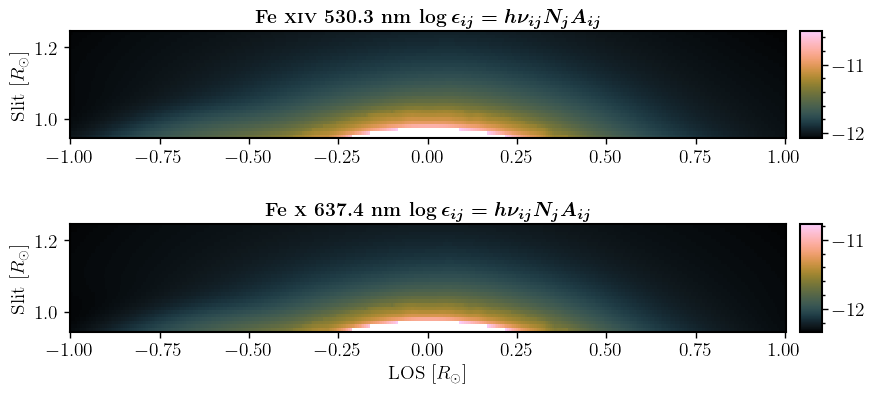

In [58]:
fig, axes = plt.subplots(2,1,figsize=(8,4),constrained_layout=True)
im = axes[0].pcolormesh(awsom_x[awsom_x_slice],awsom_z[awsom_z_slice],np.log10(FeXIV_emiss_box),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto')
plot_colorbar(im,axes[0])
axes[0].set_title(r"\textbf{Fe \textsc{xiv} 530.3 nm $\boldsymbol{\log \epsilon_{ij} = h\nu_{ij}N_jA_{ij}}$}",fontsize=14)

im = axes[1].pcolormesh(awsom_x[awsom_x_slice],awsom_z[awsom_z_slice],np.log10(FeX_emiss_box),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto')
axes[1].set_title(r"\textbf{Fe \textsc{x} 637.4 nm $\boldsymbol{\log \epsilon_{ij} = h\nu_{ij}N_jA_{ij}}$}",fontsize=14)

plot_colorbar(im,axes[1])
axes[0].set_ylabel(r"Slit $[R_\odot]$",fontsize=14)
axes[1].set_ylabel(r"Slit $[R_\odot]$",fontsize=14)
axes[1].set_xlabel(r"LOS $[R_\odot]$",fontsize=14)

for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)




In [54]:
FeXIV_emiss_box_xr = np.zeros_like(n[awsom_z_slice,:,awsom_x_slice])
FeX_emiss_box_xr = np.zeros_like(n[awsom_z_slice,:,awsom_x_slice])

In [55]:
for ii in range(awsom_z_slice.stop - awsom_z_slice.start):
    for jj in range(awsom_x_slice.stop - awsom_x_slice.start):
        FeXIV_emiss_box_xr[ii,0,jj] = FeXIV_emiss.interp(dens=np.log10(n_cut[ii,0,jj]), 
                                temp=np.log10(t_e_cut[ii,0,jj]),height=height_grid[ii,0,jj],
                                method="cubic")

In [67]:
for ii in range(awsom_z_slice.stop - awsom_z_slice.start):
    for jj in range(awsom_x_slice.stop - awsom_x_slice.start):
        FeX_emiss_box_xr[ii,0,jj] = FeX_emiss.interp(dens=np.log10(n_cut[ii,0,jj]), 
                                temp=np.log10(t_e_cut[ii,0,jj]),height=height_grid[ii,0,jj],
                                method="cubic")

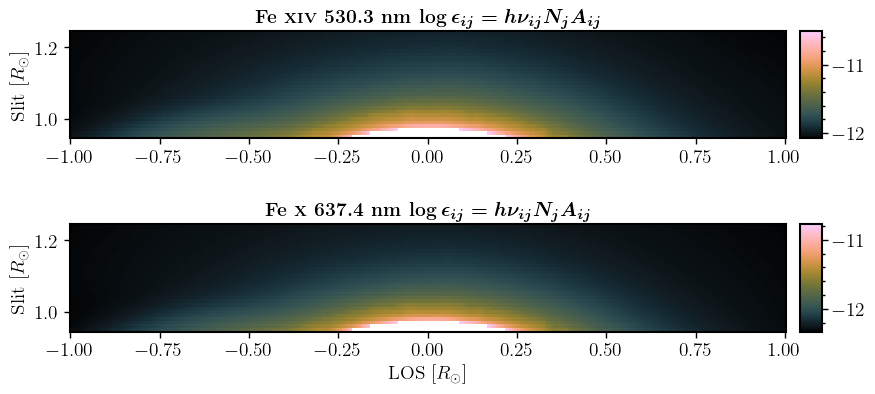

In [76]:
fig, axes = plt.subplots(2,1,figsize=(8,4),constrained_layout=True)
im = axes[0].pcolormesh(awsom_x[awsom_x_slice],awsom_z[awsom_z_slice],np.log10(FeXIV_emiss_box_xr[:,0,:]),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto')
plot_colorbar(im,axes[0])
axes[0].set_title(r"\textbf{Fe \textsc{xiv} 530.3 nm $\boldsymbol{\log \epsilon_{ij} = h\nu_{ij}N_jA_{ij}}$}",fontsize=14)

im = axes[1].pcolormesh(awsom_x[awsom_x_slice],awsom_z[awsom_z_slice],np.log10(FeX_emiss_box_xr[:,0,:]),rasterized=True,cmap=cmcm.batlowK,
                        shading='auto')
axes[1].set_title(r"\textbf{Fe \textsc{x} 637.4 nm $\boldsymbol{\log \epsilon_{ij} = h\nu_{ij}N_jA_{ij}}$}",fontsize=14)

plot_colorbar(im,axes[1])
axes[0].set_ylabel(r"Slit $[R_\odot]$",fontsize=14)
axes[1].set_ylabel(r"Slit $[R_\odot]$",fontsize=14)
axes[1].set_xlabel(r"LOS $[R_\odot]$",fontsize=14)

for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)


